Populating the interactive namespace from numpy and matplotlib


/home/bulat/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


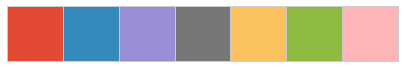

In [29]:
%pylab inline

import numpy as np
import pandas as pd
from itertools import product
import tqdm
import seaborn as sns
from scipy.stats  import pearsonr

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, SGDRegressor, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


import lightgbm as lgb

plt.style.use('ggplot')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10,5)

import itertools
palette = itertools.cycle(sns.color_palette())
sns_colors=[]
for f in range(6):
    sns_colors.append(next(palette))
sns.palplot(sns.color_palette())


RANDOM_STATE=42


### Load Data

In [137]:
#train = pd.read_hdf("data/sales_train.h5", 'df')
train = pd.read_csv("data/sales_train_v2.csv")
train['date'] = list(map(lambda x: pd.datetime.strptime(str(x), '%d.%m.%Y'), train['date'].values))        
test = pd.read_csv("data/test.csv")
sample = pd.read_csv("data/sample_submission.csv")
items = pd.read_csv("data/items.csv")
item_categories = pd.read_csv("data/item_categories.csv")
shops = pd.read_csv("data/shops.csv")
print(f"train{train.shape}, test{test.shape}, sample{sample.shape}, items{items.shape},item_categories{item_categories.shape}, shops{shops.shape}")

train(2935849, 6), test(214200, 3), sample(214200, 2), items(22170, 3),item_categories(84, 2), shops(60, 2)


In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [5]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [6]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


## Naive model

In [8]:
train["item_cnt_day"] = train["item_cnt_day"].apply(lambda x: 0 if x < 0 else x)
train["item_cnt_day"] = train["item_cnt_day"].apply(lambda x: 20 if x > 20 else x)

#### Monthly mean target

In [17]:
mean_df = train.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].agg(np.mean).to_frame()
mean_df["shop_id"] = mean_df.index.get_level_values(0)
mean_df["item_id"] = mean_df.index.get_level_values(1)
mean_df["date_block_num"] = mean_df.index.get_level_values(2)
mean_df = mean_df.reset_index(drop=True)
mean_df.head()

,item_cnt_day,shop_id,item_id,date_block_num
0,3.444444,0,30,1
1,1.571429,0,31,1
2,1.500000,0,32,0
3,1.428571,0,32,1
4,1.000000,0,33,0


In [58]:
max_month_df = mean_df.groupby(["shop_id","item_id"]).\
apply(lambda x: x[x["date_block_num"]==x["date_block_num"].max()]["item_cnt_day"].values[0])
max_month_df.shape

(424124,)

In [67]:
max_month_df = max_month_df.to_frame()
max_month_df.columns = ["pred"]
max_month_df["shop_id"] = max_month_df.index.get_level_values(0)
max_month_df["item_id"] = max_month_df.index.get_level_values(1)
max_month_df = max_month_df.reset_index(drop=True)
max_month_df.head()

,pred,shop_id,item_id
0,3.444444,0,30
1,1.571429,0,31
2,1.428571,0,32
3,1.000000,0,33
4,1.272727,0,35


#### Submit Naive model

In [6]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [90]:
test_new = pd.merge(test, max_month_df, how="left", on=["shop_id","item_id"])
test_new.shape

(214200, 4)

In [92]:
test_new["pred"].fillna(0, inplace=True)
test_new["pred"].isnull().sum()

0

In [93]:
sample["item_cnt_month"] = test_new["pred"].values
sample.head()

,ID,item_cnt_month
0,0,1.0
1,1,0.0
2,2,1.0
3,3,1.0
4,4,0.0


In [89]:
sample.to_csv("previous_value_benchmark.csv", index=False)

## EDA

### Check NaNs

In [7]:
train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [8]:
test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

In [5]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,0.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Target: item_cnt_day

In [20]:
train["item_cnt_day"] = train["item_cnt_day"].apply(lambda x: 0 if x < 0 else x)
train["item_cnt_day"] = train["item_cnt_day"].apply(lambda x: 20 if x > 20 else x)
train = train.reset_index(drop=True)

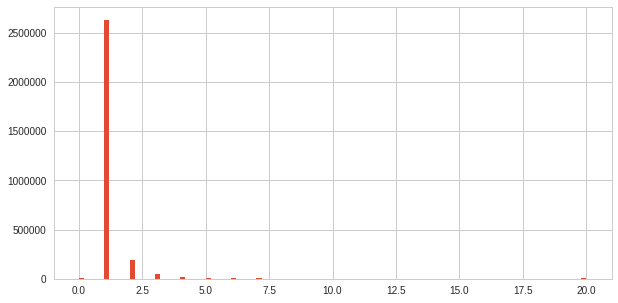

In [23]:
train["item_cnt_day"].hist(bins=100);

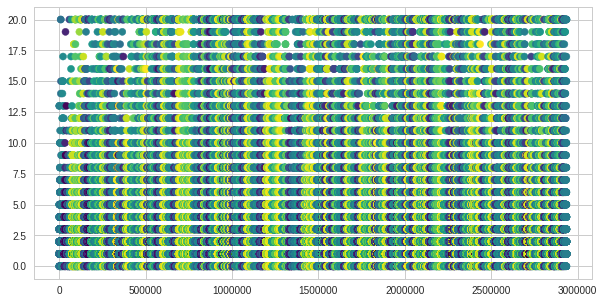

In [27]:
plt.scatter(x=train.index,y=train['item_cnt_day'], c=train['shop_id'], cmap='viridis');

## Features generation

#### Make table for all combination 'shop_id', 'item_id'

In [38]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in tqdm.tqdm_notebook(train['date_block_num'].unique()):
    cur_shops = train[train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = train[train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid.shape

(10913850, 3)

In [84]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

In [85]:
train['month'] = train['date'].apply(lambda x: x.month)
train['year'] = train['date'].apply(lambda x: x.year)

#get aggregated values for (shop_id, item_id, month)
def get_mnth(series):
    return pd.to_datetime(series.values[0]).month
def get_year(series):
    return pd.to_datetime(series.values[0]).year

gb = train.groupby(index_cols,as_index=False).agg({'item_price':{'item_price_sum':'sum',
                                                                 'item_price_mean':'mean'
                                                                },
                                                   'month': {'month':'max'},
                                                   'year':  {'year':'max'},
                                                   'item_cnt_day':{'target':'sum'}
                                                  })

#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#join aggregated data to the grid

#all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
all_data = gb.fillna(0)

#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

all_data.shape

/home/bulat/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4658: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


(1609124, 8)

### Target versus caterorical feats

In [59]:
all_data = pd.merge(all_data, items[['item_id','item_category_id']], how='left', on=['item_id'])

In [7]:
all_data.head()

,shop_id,item_id,date_block_num,item_price_sum,item_price_mean,month,year,target,item_category_id
0,0,32,0,884.0,221.0,1,2013,6.0,40
1,0,33,0,1041.0,347.0,1,2013,3.0,37
2,0,35,0,247.0,247.0,1,2013,1.0,40
3,0,43,0,221.0,221.0,1,2013,1.0,40
4,0,51,0,257.0,128.5,1,2013,2.0,57


In [9]:
all_data['item_category_id'].nunique()

84

fig, ax = plt.subplots(1,3,figsize=(18,5))
barplot = sns.barplot(x='date_block_num',y='target',data=all_data, ax=ax[0])
barplot = sns.barplot(x='shop_id',y='target',data=all_data, ax=ax[0])
barplot = sns.barplot(x='item_id',y='target',data=all_data, ax=ax[0]);

/home/bulat/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


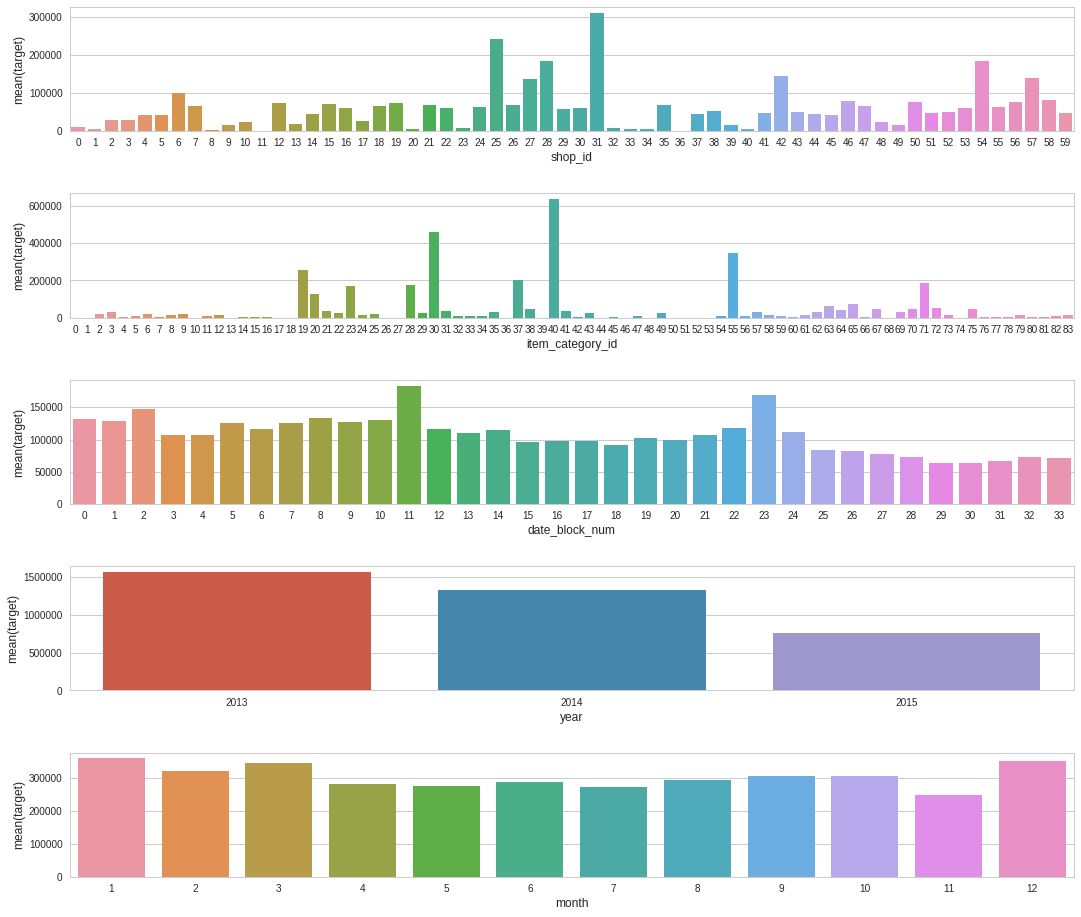

In [19]:
fig, ax = plt.subplots(5,1,figsize=(18,16))
fig.subplots_adjust(hspace=0.5)
for i,f in tqdm.tqdm_notebook(enumerate(['shop_id','item_category_id','date_block_num', 'year','month']), total=3):
    df_ = all_data.groupby(f, as_index=False)['target'].agg('sum')
    barplot = sns.barplot(x=f,y='target',data=df_, ax=ax[i]);
    #for item in barplot.get_xticklabels():
    #        item.set_rotation(90)

### Target real caterorical feats

In [86]:
all_data.at[all_data['item_price_sum']>all_data['item_price_sum'].quantile(0.99),['item_price_sum']] = 0
all_data.at[all_data['item_price_mean']>all_data['item_price_mean'].quantile(0.99),['item_price_mean']] = 0

In [60]:
#all_data = all_data[all_data['item_price_sum']<all_data['item_price_sum'].quantile(0.99)]
#all_data = all_data[all_data['item_price_mean']<all_data['item_price_mean'].quantile(0.99)]

In [88]:
all_data.shape

(1609124, 8)

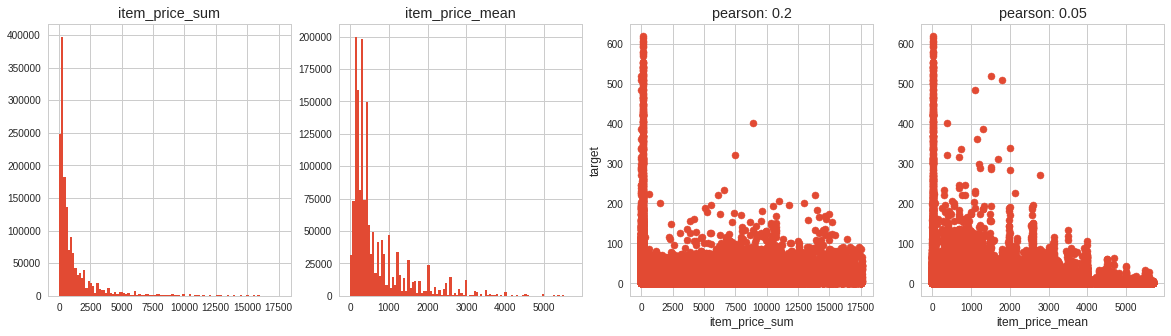

In [87]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
all_data['item_price_sum'].hist(bins=100, ax=ax[0]);
ax[0].set_title('item_price_sum')
all_data['item_price_mean'].hist(bins=100, ax=ax[1]);
ax[1].set_title('item_price_mean')
ax[2].scatter(all_data['item_price_sum'], all_data['target']);
corr = round(pearsonr(all_data['item_price_sum'], all_data['target'])[0],2)
ax[2].set_title(f"pearson: {corr}")
ax[2].set_ylabel('target')
ax[2].set_xlabel('item_price_sum')
ax[3].scatter(all_data['item_price_mean'], all_data['target']);
corr = round(pearsonr(all_data['item_price_mean'], all_data['target'])[0],2)
ax[3].set_title(f"pearson: {corr}");
ax[3].set_xlabel('item_price_mean');

In [89]:
# Add log feats for item_price_sum and item_price_mean
all_data['item_price_sum_log'] = all_data['item_price_sum'].apply(lambda x: np.log1p(x))
all_data['item_price_mean_log'] = all_data['item_price_mean'].apply(lambda x: np.log1p(x))

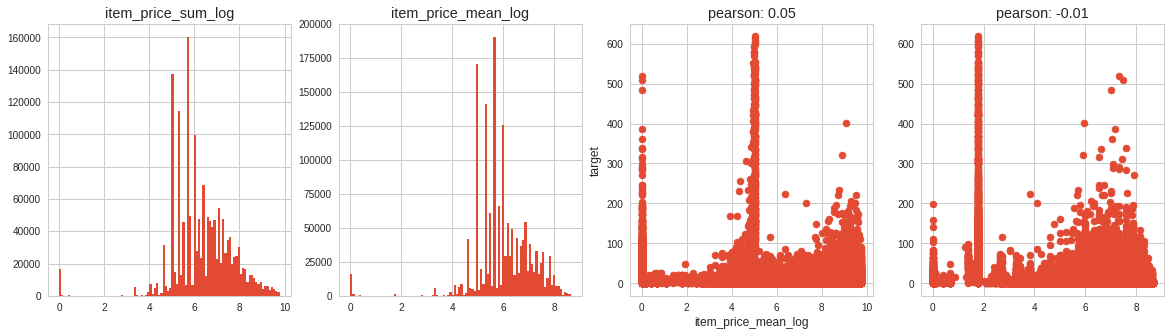

In [90]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
all_data['item_price_sum_log'].hist(bins=100, ax=ax[0]);
ax[0].set_title('item_price_sum_log')
all_data['item_price_mean_log'].hist(bins=100, ax=ax[1]);
ax[1].set_title('item_price_mean_log')
ax[2].scatter(all_data['item_price_sum_log'], all_data['target']);
corr = round(pearsonr(all_data['item_price_sum_log'], all_data['target'])[0],2)
ax[2].set_title(f"pearson: {corr}")
ax[2].set_ylabel('target')
ax[2].set_xlabel('item_price_sum_log')
ax[3].scatter(all_data['item_price_mean_log'], all_data['target']);
corr = round(pearsonr(all_data['item_price_mean_log'], all_data['target'])[0],2)
ax[3].set_title(f"pearson: {corr}");
ax[2].set_xlabel('item_price_mean_log');

#### <font color="blue"> Save data </font>

In [91]:
# Save all data
all_data.to_hdf("data/all_data.h5",'df',table=True)

### <font color="green"> Read all_data </font>

In [97]:
all_data = pd.read_hdf("data/all_data.h5",'df')
all_data.fillna(0, inplace=True)
all_data.shape

(1609124, 10)

#### Add other feats

In [67]:
all_data['item_price_sum_max'] = all_data.groupby(['shop_id','item_id'])['item_price_sum'].transform('max')
all_data['item_price_sum_min'] = all_data.groupby(['shop_id','item_id'])['item_price_sum'].transform('min')
all_data['item_price_mean_max'] = all_data.groupby(['shop_id','item_id'])['item_price_mean'].transform('max')
all_data['item_price_mean_min'] = all_data.groupby(['shop_id','item_id'])['item_price_mean'].transform('min')

In [141]:
all_data.head()

,shop_id,item_id,date_block_num,item_price_sum,item_price_mean,month,year,target,item_price_sum_max,item_price_sum_min,item_price_mean_max,item_price_mean_min
2,0,32,0,884.0,221.0,1,2013,6.0,1547.0,884.0,221.0,221.0
4,0,33,0,1041.0,347.0,1,2013,3.0,1041.0,1041.0,347.0,347.0
6,0,35,0,247.0,247.0,1,2013,1.0,2717.0,247.0,247.0,247.0
11,0,43,0,221.0,221.0,1,2013,1.0,221.0,221.0,221.0,221.0
13,0,51,0,257.0,128.5,1,2013,2.0,257.0,254.0,128.5,127.0


### Make pivot with target

In [98]:
pivot_df = all_data.pivot_table(index=["shop_id","item_id"], columns='date_block_num', 
                                values='target', aggfunc='sum', fill_value=0)
pivot_df.shape

(424124, 34)

In [99]:
pivot_df.head()

date_block_num   0   1   2   3   4   5   6   7   8   9  ...  24  25  26  27  \
shop_id item_id                                         ...                   
0       30        0  31   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        31        0  11   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        32        6  10   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        33        3   3   0   0   0   0   0   0   0   0 ...   0   0   0   0   
        35        1  14   0   0   0   0   0   0   0   0 ...   0   0   0   0   

date_block_num   28  29  30  31  32  33  
shop_id item_id                          
0       30        0   0   0   0   0   0  
        31        0   0   0   0   0   0  
        32        0   0   0   0   0   0  
        33        0   0   0   0   0   0  
        35        0   0   0   0   0   0  

[5 rows x 34 columns]

In [100]:
new_df = pd.DataFrame(pivot_df.to_records())
new_df.columns = ["shop_id","item_id"] + ['lag_'+str(i) for i in new_df.columns[2:]]
new_df = new_df.rename(index=str, columns={"lag_33":"target"})
new_df.head()

,shop_id,item_id,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,target
0,0,30,0,31,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,0,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,6,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get window target feats

In [101]:
df_final = new_df[list(new_df.columns[:2]) + list(new_df.columns[-7:])].copy()
#df_final = new_df.copy()
for w in tqdm.tqdm_notebook([6,12,24,32]):
    df_roll = new_df[new_df.columns[2:-1]].T.rolling(w).mean().T.dropna(how="all", axis=1)
    df_roll.columns = ['tg_mean_'+str(w)+'_'+str(i) for i in range(df_roll.shape[1])]
    df_final = pd.concat([df_final, df_roll], axis=1)
df_final.shape

Exception in thread Thread-19:
Traceback (most recent call last):
  File "/home/bulat/anaconda2/envs/py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/bulat/anaconda2/envs/py36/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/bulat/anaconda2/envs/py36/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



(424124, 71)

#### Get other feats from all_data

In [102]:
df_lst = []
for f in tqdm.tqdm_notebook(['item_price_sum','item_price_mean',
                             'item_price_sum_log','item_price_mean_log',
                             #'item_price_sum_max','item_price_sum_min',
                             #'item_price_mean_max','item_price_mean_min'
                            ]):
    
    pivot_df = all_data.pivot_table(index=["shop_id","item_id"], columns='date_block_num', 
                                    values=f, aggfunc='sum', fill_value=0)
    
    df_ = pd.DataFrame(pivot_df.to_records())
    df_.columns = ["shop_id","item_id"] + [f+'_lag_'+str(i) for i in df_.columns[2:]]
    df_ = df_.drop(df_.columns[-1], axis=1)
    
    df_i = df_[list(df_.columns[:2]) + list(df_.columns[-2:])].copy()
    for w in tqdm.tqdm_notebook([24,32]):
        df_roll = df_[df_.columns[2:]].T.rolling(w).mean().T.dropna(how="all", axis=1)
        df_roll.columns = [f[-9:]+'_'+str(w)+'_'+str(i) for i in range(df_roll.shape[1])]
        df_i = pd.concat([df_i, df_roll], axis=1)
    
    df_lst.append(df_i)

#### Merge DF with target lags with DF with other features

In [103]:
for df in tqdm.tqdm_notebook(df_lst):
    df_final = pd.merge(df_final, df, how="left", on=["shop_id","item_id"])
df_final.shape

(424124, 127)

#### Add Items category

In [104]:
df_final = pd.merge(df_final, items[['item_id','item_category_id']], on = ['item_id']).fillna(0)
df_final.shape

(424124, 128)

In [105]:
# Save final data
df_final.to_hdf("df_final.h5", 'df',table=True)

### <font color="green"> Read final data </font>

In [106]:
df_final = pd.read_hdf("df_final.h5", 'df')
df_final.shape

(424124, 128)

### Split train/test

In [107]:
X = df_final.drop(['shop_id', 'item_id', 'target'], axis=1)
y = df_final['target']
indices = range(X.shape[0])
X_train, X_valid, y_train, y_valid, idx_trn, idx_vld = train_test_split(X, y, indices, 
                                                                        test_size=0.2, shuffle=True,
                                                                        random_state=123, 
                                                                        #stratify = y
                                                                       )
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((339299, 125), (84825, 125), (339299,), (84825,))

### Encode categorical features
- Expanding mean scheme

In [108]:
def expand_encode(df_trn, df_val, cat_lst):
    for f in tqdm.tqdm_notebook(cat_lst):
        # train set
        cumsum = df_trn.groupby(f)['target'].cumsum() - df_trn['target']
        cumcnt = df_trn.groupby(f).cumcount()
        df_trn[f+'_trgt_expand'] = cumsum/cumcnt
        df_trn[f+'_trgt_expand'] = df_trn[f+'_trgt_expand'].fillna(df_trn['target'].mean())

        # test set
        cumsum_tst = df_val[f].map(cumsum)
        cumcnt_tst = df_val[f].map(cumcnt)
        df_val[f+'_trgt_expand'] = cumsum_tst/cumcnt_tst
        df_val[f+'_trgt_expand'] = df_val[f+'_trgt_expand'].fillna(df_trn['target'].mean())
        
    return df_trn, df_val

In [109]:
df_trn = df_final.iloc[idx_trn].copy()
df_val = df_final.iloc[idx_vld].copy()
cat_lst = ['shop_id', 'item_id', 'item_category_id']
df_trn, df_val = expand_encode(df_trn, df_val, cat_lst)

In [110]:
drop_feats = ['shop_id', 'item_id', 'target', 'item_category_id']
X = pd.concat([df_trn,df_val], axis=1).drop(drop_feats, axis=1) 
y = pd.concat([df_trn,df_val], axis=1)['target']
X_train = df_trn.drop(drop_feats, axis=1) 
X_valid = df_val.drop(drop_feats, axis=1)  
y_train = df_trn['target'] 
y_valid = df_val['target'] 

## Modeling

### Linear model

In [111]:
sgd = make_pipeline(StandardScaler(), LinearRegression())
sgd.fit(X_train, y_train)
sgd_pred = sgd.predict(X_valid)
print('rmse:{}'.format(round(np.sqrt(mean_squared_error(y_valid, sgd_pred)),4)))

rmse:1.1584


### RandomForest

In [122]:
%%time
rf = RandomForestRegressor( n_estimators = 50,
                            max_depth = 10,
                            random_state=RANDOM_STATE, 
                            n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
print('rmse:{}'.format(round(np.sqrt(mean_squared_error(y_valid, rf_pred)),4)))

rmse:1.3788
CPU times: user 17min 15s, sys: 1.19 s, total: 17min 16s
Wall time: 4min 42s


### LightGBM

In [116]:
lgb_params = {   'learning_rate': 0.01,
                 'max_depth': 7,
                 'min_data_in_leaf': 5,
                 'n_estimators': 500,
                 'num_leaves': 75,
                 #'reg_alpha': params['reg_alpha'],
                 #'reg_lambda': params['reg_lambda'],
                 'objective': 'mse',
                 'random_state': RANDOM_STATE,
                 'n_jobs': -1,
              
             }

In [117]:
%%time
lgbm = lgb.LGBMRegressor(**lgb_params)
lgbm.fit(X_train, y_train)
lgb_pred = lgbm.predict(X_valid)
print('rmse:{}'.format(round(np.sqrt(mean_squared_error(y_valid, lgb_pred)),4)))

rmse:1.2648
CPU times: user 1min 41s, sys: 848 ms, total: 1min 42s
Wall time: 29.1 s


### Blending

In [128]:
blend_pred = np.vstack([
                        lgb_pred,
                        rf_pred,
                        sgd_pred
                       ]).T.mean(axis=1)
print('rmse:{}'.format(round(np.sqrt(mean_squared_error(y_valid, blend_pred)),4)))

rmse:1.1827


In [130]:
alphas_to_try = np.linspace(0, 1, 1001)

# YOUR CODE GOES HERE
score = 1000.
best_alpha = 0
for a in tqdm.tqdm_notebook(alphas_to_try):
    avg_pred = np.add(a*lgb_pred, (1-a)*sgd_pred)
    score_temp = np.sqrt(mean_squared_error(y_valid,avg_pred))
    if  score_temp < score:
        best_alpha = a
        score = score_temp 
        
#best_alpha = # YOUR CODE GOES HERE
avg_pred = best_alpha*lgb_pred + (1-best_alpha)*sgd_pred
avg_score = np.sqrt(mean_squared_error(y_valid,avg_pred))

print('Best alpha: %f; Corresponding rmse score on train: %f' % (best_alpha, avg_score))


Best alpha: 0.312000; Corresponding rmse score on train: 1.129303


## Submit

### Encode categorical features
- Expanding mean scheme

In [131]:
def expand_encode_1(df_trn, cat_lst):
    for f in tqdm.tqdm_notebook(cat_lst):
        # train set
        cumsum = df_trn.groupby(f)['target'].cumsum() - df_trn['target']
        cumcnt = df_trn.groupby(f).cumcount()
        df_trn[f+'_trgt_expand'] = cumsum/cumcnt
        df_trn[f+'_trgt_expand'] = df_trn[f+'_trgt_expand'].fillna(df_trn['target'].mean())
        
    return df_trn

In [132]:
cat_lst = ['shop_id', 'item_id', 'item_category_id']
df_final_cat = expand_encode_1(df_final, cat_lst)

In [133]:
df_final_cat.shape

(424124, 131)

In [134]:
drop_feats = ['shop_id', 'item_id', 'target', 'item_category_id']
X = df_final_cat.drop(drop_feats, axis=1)
y = df_final_cat['target']

In [138]:
test_df = test.copy()
test_df = pd.merge(test, df_final_cat, how = "left", on = ["shop_id", "item_id"]).fillna(0.0)
test_df.shape

(214200, 132)

In [139]:
X_test = test_df.drop(['ID']+drop_feats, axis=1)
X_test.shape

(214200, 127)

### Train full model

In [140]:
sgd.fit(X, y)
sgd_pred_tst = sgd.predict(X_test)

In [143]:
%%time
lgbm = lgb.LGBMRegressor(**lgb_params)
lgbm.fit(X, y)
lgb_pred_tst = lgbm.predict(X_test)

CPU times: user 2min, sys: 1.13 s, total: 2min 1s
Wall time: 33.9 s


In [144]:
avg_pred_tst = best_alpha*lgb_pred_tst + (1-best_alpha)*sgd_pred_tst

In [145]:
# Normalize prediction to [0-20]
avg_pred_tst = list(map(lambda x: min(20,max(x,0)), list(avg_pred_tst)))
sub_df = pd.DataFrame({'ID':test_df.ID,'item_cnt_month': avg_pred_tst })
sub_df.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.365780
std,61834.358168,0.849138
min,0.000000,0.000000
25%,53549.750000,0.126003
50%,107099.500000,0.270823
75%,160649.250000,0.270823
max,214199.000000,20.000000


In [147]:
sub_df.to_csv('submissions/lgbm_5_filter_price.csv',index=False)